In [2]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [14]:
# load data #
api_key = '354630feeb4a4077ad012d7eb14015210a778caad7a680af30b1129ef4c6154d'
symbol = 'ETH'  # Example: BitCoin Cash #
url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={symbol}&tsym=USD&limit=2000&api_key={api_key}'

response = requests.get(url)
data = response.json()

# prepare dataFrame #
crypto_df = pd.DataFrame(data['Data']['Data'])
crypto_df['time'] = pd.to_datetime(crypto_df['time'], unit='s')  # Convert timestamp to datetime #
crypto_df.set_index('time', inplace=True)

# display few records #
crypto_df.head()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2019-05-19,265.38,259.15,234.04,3040455.74,7.926642e+08,260.71,multiply,BTC
2019-05-20,257.70,248.83,260.71,2923763.43,7.380340e+08,252.43,multiply,BTC
2019-05-21,260.06,250.76,252.43,2942581.05,7.495671e+08,254.73,multiply,BTC
2019-05-22,248.64,239.94,254.73,2883661.97,7.024683e+08,243.60,multiply,BTC
2019-05-23,252.84,242.36,243.60,2881253.44,7.073780e+08,245.51,multiply,BTC


In [15]:
# Check for missing values #
print(crypto_df.isnull().sum())

# Focus on 'close' prices #
crypto_df = crypto_df[['close']]
crypto_df.columns = ['Close']

high                0
low                 0
open                0
volumefrom          0
volumeto            0
close               0
conversionType      0
conversionSymbol    0
dtype: int64


In [16]:
crypto_df.shape

(2001, 1)

In [24]:
# Scale the data #
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(crypto_df['Close'].values.reshape(-1, 1))

In [25]:
# Create training and testing datasets #
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step
time_step = 5
X, y = create_dataset(scaled_data, time_step)

In [26]:
# Split into train and test sets #
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features] #
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [27]:
# build and train LSTM model #
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0551 
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016    
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 16/10

In [28]:
# predictions #
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions to original scale #
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform y values #
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step


In [36]:
# Training metrics #
train_mae = mean_absolute_error(y_train_inv, train_predict)
train_mse = mean_squared_error(y_train_inv, train_predict)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, train_predict)

# Testing metrics #
test_mae = mean_absolute_error(y_test_inv, test_predict)
test_mse = mean_squared_error(y_test_inv, test_predict)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_inv, test_predict)

# Print the metrics #
print("Training Evaluation:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MSE: {train_mse:.4f}")

print("\nTest Evaluation:")
print(f"R2 Score: {test_r2:.4f}")
print(f"MSE: {test_mse:.4f}")

Training Evaluation:
R2 Score: 0.9908
MSE: 12685.7321

Test Evaluation:
R2 Score: 0.9479
MSE: 19444.6475


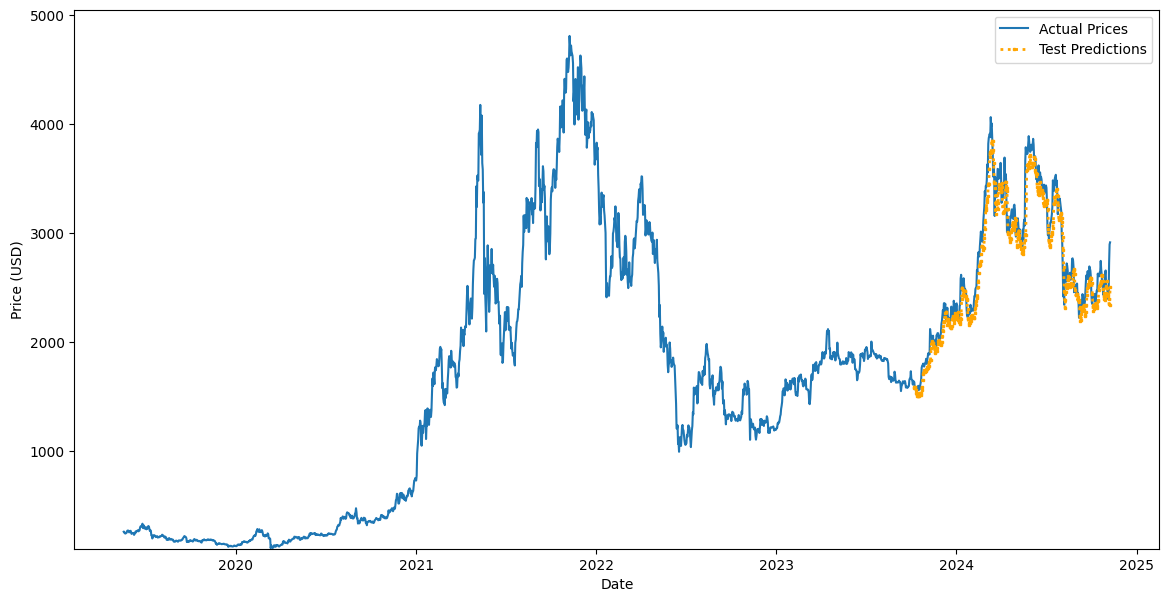

In [38]:
# visulize the data #
# Create a new DataFrame for plotting
train_size = len(train_predict)
test_size = len(test_predict)

# Create an array for the full dataset to plot
full_data = np.empty((len(crypto_df), 1))
full_data[:] = np.nan  # Fill with NaNs

# Fill in the train predictions
full_data[time_step:train_size + time_step] = train_predict

# Fill in the test predictions
full_data[train_size + time_step + 1:] = test_predict

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(crypto_df.index, crypto_df['Close'], label='Actual Prices')
#plt.plot(crypto_df.index, full_data, color='blue', label='Predicted Prices', linewidth=2)
# plt.plot(crypto_df.index[time_step:train_size + time_step], train_predict, color='blue', label='Train Predictions', linewidth=2, linestyle=':', marker='s', markersize=2)
plt.plot(crypto_df.index[train_size + time_step + 1:], test_predict, color='orange', label='Test Predictions', linewidth=2, linestyle=':', marker='s', markersize=2)

plt.ylim(crypto_df['Close'].min() * 0.95, crypto_df['Close'].max() * 1.05)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()